# Requirements
Since I had pretrained ran these on a GPU compatible runtime from Google Colab, where I used my own GPU, importing model files from there requires PyTorch version 1.8.1

In [ ]:
!pip uninstall torch
!pip install torch==1.8.1
!pip uninstall torchvision
!pip install torchvision==0.9.1

Found existing installation: torch 1.11.0+cu113
Uninstalling torch-1.11.0+cu113:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.7/dist-packages/caffe2/*
    /usr/local/lib/python3.7/dist-packages/torch-1.11.0+cu113.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torch/*
Proceed (y/n)? y
y
y
y
  Successfully uninstalled torch-1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 804.1 MB 2.8 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.8.1 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.8.1 which is incompatible.
torchaudio 0.11.0+cu113 re

Functional imports for Code

In [ ]:
import math
import torch.nn.functional as F
import pickle
import random
import pandas as pd
import numpy as np
from collections import Counter 
import torchvision
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%cd "drive/MyDrive/CSE354FinalProj"

/content/drive/MyDrive/CSE354FinalProj


In [ ]:
data = pd.read_csv("./flickr8k/captions.txt", sep = ",")
print(len(data))

40455


This is a function to weed out data pieces that are too small for use.

In [ ]:
def filter(value):
  sentence = []
  for word in value:
    if len(word) <= 1:
      continue
    else:
      sentence.append(word)
  return sentence

# Data Cleanup
Here, I reorganize the data in a Pandas DataFrame, for easier access, adding end of sentence and start of sentence tasks, and filtering out values as needed/splitting captions into individual tokens.

In [ ]:
data['cleaned_caption'] = data['caption'].apply(lambda x: ['<SOS>'] + [y.lower() if y.isalpha else ' ' for y in x.split(" ")] + ['<EOS>'])
data['cleaned_caption'] = data['cleaned_caption'].apply(lambda x: filter(x))

In [ ]:
data['sequence_length'] = data['cleaned_caption'].apply(lambda x: len(x))
max_sequence_length = data['sequence_length'].max()
data.drop(['sequence_length'], axis = 1, inplace = True)

In [ ]:
data['cleaned_caption'] = data['cleaned_caption'].apply(lambda x: x + ['<pad>'] * (max_sequence_length - len(x)))

In [ ]:
corpus = data['cleaned_caption'].apply(lambda x: " ".join(x)).str.cat(sep = ' ').split(' ')
word_store = Counter(corpus)
word_store = sorted(word_store, key = lambda x: word_store.get(x), reverse = True)

Here, I create the mapping of words to IDs and vice versa for indexing and correlation.

In [ ]:
vocab_size = len(word_store)
idx_word_map = {
    index: x for index, x in enumerate(word_store)
}
word_idx_map = {
    word: x for x, word in enumerate(word_store)
}

In [ ]:
data['text_sequence'] = data['cleaned_caption'].apply(lambda x: [word_idx_map[word] for word in x])

In [ ]:
data = data.sort_values(by = 'image')
cutoff = int(0.9 * len(data))
train_split = data.iloc[:cutoff]
validation_split = data.iloc[cutoff:]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else "cpu")

In [ ]:
filtered_train = train_split[['image']].drop_duplicates()
filtered_val = validation_split[['image']].drop_duplicates()

This is a function that normalizes our data and converts it to the right data type.

In [ ]:
class DataNormalize():

  def __init__(self, data):
    self.data = data
    self.scaling = transforms.Resize([244, 244])
    self.normalization = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                              std = [0.229, 0.224, 0.225])
    self.to_tensor = transforms.ToTensor()
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image_name = self.data.iloc[idx]['image']
    filename = './flickr8k/Images/' + str(image_name)
    img = Image.open(filename)
    transformed_img = self.normalization(self.to_tensor(self.scaling(img)))

    return image_name, transformed_img

In [ ]:
training_features = DataNormalize(filtered_train)
training_dataloader = DataLoader(training_features, batch_size = 1, shuffle = False)

In [ ]:
val_features = DataNormalize(filtered_val)
val_dataloader = DataLoader(val_features, batch_size = 1, shuffle = False)

# Encoder
Here I pull the pretrained ResNet18 Model and take the 4th layer from it to encode our images.

In [ ]:
encoder = torchvision.models.resnet18(pretrained = True).to(device)
encoder.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
enc_layer_4 = encoder._modules.get('layer4').to(device)

In [ ]:
def vectorize(image):
  image = Variable(image)
  embedding = torch.zeros(1, 512, 8, 8)
  def duplicate(m, i, o):
    embedding = o.data
  val = enc_layer_4.register_forward_hook(duplicate)
  encoder(image)
  val.remove()
  return embedding

In [ ]:
feature_train = {}
for file_path, image in tqdm(training_dataloader):
  image = image.to(device)
  embedding = vectorize(image)
  feature_train[file_path[0]] = embedding
save_embeds = open("./ImageTrainEmbed.pk1", "wb")
pickle.dump(feature_train, save_embeds)
save_embeds.close()

  0%|          | 0/7282 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
feature_val = {}
for file_path, image in tqdm(val_dataloader):
  image = image.to(device)
  embedding = vectorize(image)
  feature_val[file_path[0]] = embedding
save_embeds = open("./ImageValEmbed.pk1", "wb")
pickle.dump(feature_val, save_embeds)
save_embeds.close()

After having saved the encodings into a pickle file, I import them in. This is for the sake of testing since I have been messing with the encoder a bit and have the encodings saved from successful trials.

In [ ]:
class EncodedDataset():

  def __init__(self, data, file):
    self.data = data
    self.encoded_files = pd.read_pickle(file)
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    captions = self.data.iloc[index]['text_sequence']
    target_caption = captions[1:]+[0]

    filepath = self.data.iloc[index]['image']
    tensor = self.encoded_files[filepath].permute(0, 2, 3, 1)
    tensor = tensor.view(tensor.size(0), -1, tensor.size(3))

    return torch.tensor(captions), torch.tensor(target_caption), torch.tensor(tensor)

In [ ]:
train_data = EncodedDataset(train_split, 'transformer_encoded_data/ImageTrainEmbed.pkl')
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True)

val_data = EncodedDataset(validation_split, 'transformer_encoded_data/ImageValEmbed.pkl')
val_dataloader = DataLoader(val_data, batch_size = 32, shuffle = True)

# Positional Embeddings
Position Embeddings are pretty important in sentence word order and embedding order for the tokens read in, so it's a part of our Decoder.

The Position Embeddings use embedding, as well as the sine and cosine of a log raised expression to express the positional encodings of the tokens. Still a little bit mysterious to me but this was mentioned in a TensorFlow Kaggle Notebook about Transformers for Image Captioning by Abishek Bashyal.

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_sequence_length):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

# Decoding Model
Here we import the PyTorch Transformer Decoder and make a few more layers for embedding and fully connected layers for shape formatting. We also calculate a mask in this case, with the padding mask as well to fill in values for 1 and 0.

In [ ]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

Here, I chose an arbitrary learning rate, and tried using the scheduler, but unfortunately couldn't get it configured correctly in time. The optimizer in this case is Adam.

In [ ]:
model = Decoder(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = torch.nn.CrossEntropyLoss(reduction = 'none')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


This was my last training batch, which ended at 9 due to GPU Runtime running out for Colab. These models were ran multiple times and saved, which is why I import in my own further down the line.

In [ ]:
for epoch in tqdm(range(10)):
  total_train_loss = 0
  total_train_words = 0
  total_val_loss = 0
  total_val_words = 0
  model.train()

  for caption, target, img in train_dataloader:
    optimizer.zero_grad()

    image = img.squeeze(1).to(device)
    captions = caption.to(device)
    target = target.to(device)

    output, pad = model.forward(image, captions)
    output = output.permute(1, 2, 0)

    loss = criterion(output, target)
    mask_loss = torch.mul(loss, pad)

    averaged_loss = torch.sum(mask_loss)/torch.sum(pad)
    averaged_loss.backward()
    optimizer.step()
    total_train_loss += torch.sum(mask_loss).detach().item()
    total_train_words += torch.sum(pad)
    
  total_train_loss = total_train_loss/total_train_words

  model.eval()
  with torch.no_grad():
    for caption, target, image in val_dataloader:
      image = image.squeeze(1).to(device)
      target = target.to(device)
      caption = caption.to(device)

      output, pad = model.forward(image, caption)
      output = output.permute(1, 2, 0)

      loss = criterion(output, target)
      mask_loss = torch.mul(loss, pad)

      total_val_loss += torch.sum(mask_loss).detach().item()
      total_val_words += torch.sum(pad)
  total_val_loss = total_val_loss / total_val_words

  print("Epoch [", epoch, "]: Training Loss: ", total_train_loss.item())
  print("Validation Loss: ", total_val_loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [ 0 ]: Training Loss:  3.9899301528930664
Validation Loss:  3.4250104427337646
Epoch [ 1 ]: Training Loss:  3.1318275928497314
Validation Loss:  3.196549892425537
Epoch [ 2 ]: Training Loss:  2.771801233291626
Validation Loss:  3.1334917545318604
Epoch [ 3 ]: Training Loss:  2.484041690826416
Validation Loss:  3.134608030319214
Epoch [ 4 ]: Training Loss:  2.2336208820343018
Validation Loss:  3.1573493480682373
Epoch [ 5 ]: Training Loss:  2.0052945613861084
Validation Loss:  3.212606430053711
Epoch [ 6 ]: Training Loss:  1.799315333366394
Validation Loss:  3.2590556144714355
Epoch [ 7 ]: Training Loss:  1.612963318824768
Validation Loss:  3.3384287357330322
Epoch [ 8 ]: Training Loss:  1.4423904418945312
Validation Loss:  3.4377477169036865
Epoch [ 9 ]: Training Loss:  1.2879213094711304
Validation Loss:  3.5344440937042236


# Model File
Here, I load the best of the done tests for pretrained models, since we did a few trials.

In [ ]:
model = torch.load('./models/transformer-decode-model')

House cleaning for sentence formation, specifically padding, end, and beginning of sentence.

In [ ]:
start_token = word_idx_map['<SOS>']
end_token = word_idx_map['<EOS>']
pad_token = word_idx_map['<pad>']
max_length = 33

Here we import in the Validation Embeddings, which were created alongside the training ones.

In [ ]:
validation_embeddings = pd.read_pickle('transformer_encoded_data/ImageValEmbed.pkl')

This method acts as a sort of evaluation method for the model, where a single image is passed in to get the vector output from the decoder. This is taken and the next word is sampled from the rest of the output values and embeddings.

In [ ]:
def evaluate_single(x, path):
  image = 'flickr8k/Images/' + str(path)
  image = Image.open(image).convert("RGB")
  plt.imshow(image)

  model.eval()
  image_out = validation_split[validation_split['image'] == path]
  true_caption = image_out['caption'].tolist()
  embedded_img = validation_embeddings[path].to(device).permute(0, 2, 3, 1)
  embedded_img = embedded_img.view(embedded_img.size(0), -1, embedded_img.size(3))

  input_padded_sequence = [pad_token] * max_length
  input_padded_sequence[0] = start_token

  input_sequence = torch.tensor(input_padded_sequence).unsqueeze(0).to(device)
  sentence = []
  with torch.no_grad():
    for iteration in range(0, 33):
      output, pad = model.forward(embedded_img, input_sequence)
      output = output[iteration, 0, :]

      val = torch.topk(output, x).values.tolist()
      index = torch.topk(output, x).indices.tolist()

      next_word_idx = random.choices(index, val, k = 1)[0]
      next_word = idx_word_map[next_word_idx]

      input_sequence[:, iteration + 1] = next_word_idx

      if next_word == '<EOS>':
        break
      
      sentence.append(next_word)
  print("Predicted Caption: ", " ".join(sentence))
  # print("Actual Caption: ", true_caption[0])

Here we have a clown with two posters of people. It makes sense that the model cannot pick up on the clown, since it is not too popular of a term in the set.

AttributeError: ignored

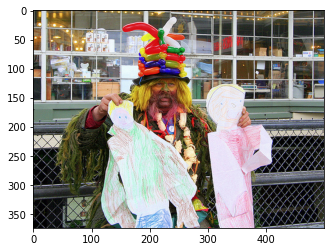

In [ ]:
evaluate_single(1, filtered_val.iloc[13]['image'])

This case is a little dog running through a field. The model is accurate in reading the background and the environment, but does not pick up on the dog. This may be due to the size of/importance of the feature embedding for the dog.

Predicted Caption:  the little boy is running through the grass


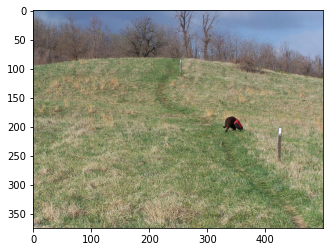

In [ ]:
evaluate_single(1, filtered_val.iloc[47]['image'])

In this case, I feel like the orientation of the man isn't accurately being depicted, since he is lying down, and the metal bars seem to be confusing to the model, which also makes sense due to low frequency and most likely to do with the encoder's captured information.

Predicted Caption:  the man is sitting on the helmet and is sitting on the helmet


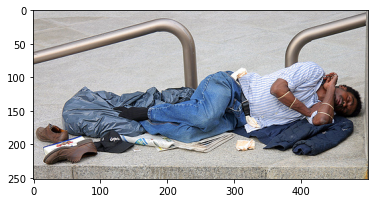

In [ ]:
evaluate_single(1, filtered_val.iloc[6]['image'])

I have come to realize there are a lot of dogs in this dataset, and it makes sense that the model is accurate at identifying those. This is by far the best caption I've seen.

Predicted Caption:  man is doing couch on city


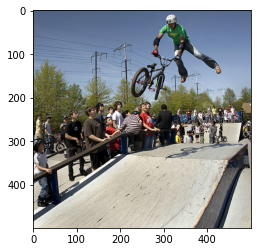

In [ ]:
evaluate_single(1, filtered_val.iloc[180]['image'])

Here I take 4 different samples, all of which get it almost right, except the 2nd which is fairly accurate. What's interesting is the shirtless most likely has to do with color, and the orange toy seems to be from the reflection, but I'm not really sure what leash water is.

Predicted Caption:  dog shirtless through water
Actual Caption:  ['A dog with yellow fur swims , neck deep , in water .', 'A golden retreiver swimming in the water .', 'A brown dog swimming in murky water .', 'A brown dog swims in the murky water .', 'A yellow dog is swimming in the water .']
Predicted Caption:  dog is swimming through the water
Actual Caption:  ['A dog with yellow fur swims , neck deep , in water .', 'A golden retreiver swimming in the water .', 'A brown dog swimming in murky water .', 'A brown dog swims in the murky water .', 'A yellow dog is swimming in the water .']
Predicted Caption:  dog is swimming through leash water
Actual Caption:  ['A dog with yellow fur swims , neck deep , in water .', 'A golden retreiver swimming in the water .', 'A brown dog swimming in murky water .', 'A brown dog swims in the murky water .', 'A yellow dog is swimming in the water .']
Predicted Caption:  dog is swimming with an orange toy
Actual Caption:  ['A dog with yellow fur swims , 

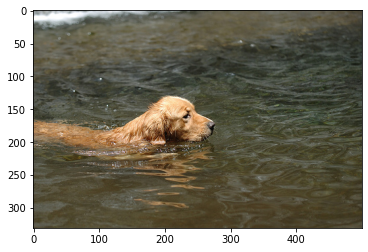

In [ ]:
evaluate_single(1, filtered_val.iloc[24]['image'])
evaluate_single(2, filtered_val.iloc[24]['image'])
evaluate_single(3, filtered_val.iloc[24]['image'])
evaluate_single(4, filtered_val.iloc[24]['image'])